<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calculate-albedo" data-toc-modified-id="Calculate-albedo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate albedo</a></span></li>


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
region="TWP"

In [41]:
chunk_dict = {"time":500, "lat":400, "lon":1440} # "grid_size":500000} 
ds = xr.open_dataset(ap.get_twp_file("DATA", "rad"), chunks=chunk_dict)
da_olr = ds.adj_atmos_lw_up_all_toa_1h
da_swu = ds.adj_atmos_sw_up_all_toa_1h
da_swd = ds.adj_atmos_sw_down_all_toa_1h
ni_olr = xr.open_dataset(ap.get_twp_file("NICAM", "rlut"), chunks=chunk_dict).rlut
ni_swu = xr.open_dataset(ap.get_twp_file("NICAM", "rsut"), chunks=chunk_dict).rsut
ni_swd = xr.open_dataset(ap.get_twp_file("NICAM", "rsdt"), chunks=chunk_dict).rsdt
um_olr = xr.open_dataset(ap.get_twp_file("UM", "rlut"), chunks=chunk_dict).rlut
um_swu = xr.open_dataset(ap.get_twp_file("UM", "rsut"), chunks=chunk_dict).rsut
um_swd = xr.open_dataset(ap.get_twp_file("UM", "rsdt"), chunks=chunk_dict).rsdt
# ge_olr = xr.open_dataset(ap.get_twp_file("GEOS", "rlut"), chunks=chunk_dict).rlut
# ge_swu = xr.open_dataset(ap.get_twp_file("GEOS", "rsut"), chunks=chunk_dict).rsut
# ge_swd = xr.open_dataset(ap.get_twp_file("GEOS", "rsdt"), chunks=chunk_dict).rsdt
sa_olr = xr.open_dataset(ap.get_twp_file("SAM", "rlt"), chunks=chunk_dict).rlt
sa_swn = xr.open_dataset(ap.get_twp_file("SAM", "rst"), chunks=chunk_dict).rstacc
sa_swd = xr.open_dataset(ap.get_twp_file("NICAM", "rsdt"), 
                         chunks=chunk_dict).rsdt.sel(time=sa_swn.time, 
                                                     lat=sa_swn.lat, 
                                                     lon=sa_swn.lon, 
                                                     method="nearest")
sa_swu = sa_swd.where>10 - sa_swn
# sc_olr = xr.open_dataset(ap.get_twp_file("SCREAM", "rlt"), chunks=chunk_dict).rlt
# sc_swn = xr.open_dataset(ap.get_twp_file("SCREAM", "rst"), chunks=chunk_dict).rst
# sc_swd = xr.open_dataset(ap.get_twp_file("SCREAM", "rsdt"), chunks=chunk_dict).rsdt

sa_swu

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s


<xarray.DataArray 'rstacc' (time: 2976, lat: 256, lon: 256)>
dask.array<subtract, shape=(2976, 256, 256), dtype=float32, chunksize=(500, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-29T23:45:00
  * lon      (lon) float32 143.0 143.0 143.1 143.1 ... 152.9 152.9 152.9 153.0
  * lat      (lat) float32 -4.974 -4.936 -4.897 -4.858 ... 4.897 4.936 4.974
Attributes:
    standard_name:  toa_net_downward_shortwave_flux_accumulated
    long_name:      Net SW at TOA (accum)
    units:          J/m2
    cell_methods:   time: mean
    origin:         SWNTAC

# Coarsen to 1x1 deg

In [15]:
ni_olr = ni_olr.coarsen(lat=len(ni_olr.lat)//10, lon=len(ni_olr.lon)//10, boundary='trim').mean()
ni_swu = ni_swu.coarsen(lat=len(ni_swu.lat)//10, lon=len(ni_swu.lon)//10, boundary='trim').mean()
ni_swd = ni_swd.coarsen(lat=len(ni_swd.lat)//10, lon=len(ni_swd.lon)//10, boundary='trim').mean()
sa_olr = sa_olr.coarsen(lat=len(sa_olr.lat)//10, lon=len(sa_olr.lon)//10, boundary='trim').mean()
sa_swu = sa_swu.coarsen(lat=len(sa_swu.lat)//10, lon=len(sa_swu.lon)//10, boundary='trim').mean()
sa_swd = sa_swd.coarsen(lat=len(sa_swd.lat)//10, lon=len(sa_swd.lon)//10, boundary='trim').mean()
um_olr = um_olr.coarsen(latitude=len(um_olr.latitude)//10, longitude=len(um_olr.longitude)//10, boundary='trim').mean()
um_swu = um_swu.coarsen(latitude=len(um_swu.latitude)//10, longitude=len(um_swu.longitude)//10, boundary='trim').mean()
um_swd = um_swd.coarsen(latitude=len(um_swd.latitude)//10, longitude=len(um_swd.longitude)//10, boundary='trim').mean()
# ge_olr = ge_olr.coarsen(lat=len(ge_olr.lat)//10, lon=len(ge_olr.lon)//10, boundary='trim').mean()
# ge_swu = ge_swu.coarsen(lat=len(ge_swu.lat)//10, lon=len(ge_swu.lon)//10, boundary='trim').mean()
# ge_swd = ge_swd.coarsen(lat=len(ge_swd.lat)//10, lon=len(ge_swd.lon)//10, boundary='trim').mean()


In [32]:
da_olr = da_olr.where(da_olr.time.dt.hour>=1,da_olr.time.dt.hour<=3)
da_swu = da_swu.where(da_olr.time.dt.hour>=1,da_olr.time.dt.hour<=3)
da_swd = da_swd.where(da_olr.time.dt.hour>=1,da_olr.time.dt.hour<=3)
ni_olr = ni_olr.where(ni_olr.time.dt.hour>=1,ni_olr.time.dt.hour<=3)
ni_swu = ni_swu.where(ni_olr.time.dt.hour>=1,ni_olr.time.dt.hour<=3)
ni_swd = ni_swd.where(ni_olr.time.dt.hour>=1,ni_olr.time.dt.hour<=3)
sa_olr = sa_olr.where(sa_olr.time.dt.hour>=1,sa_olr.time.dt.hour<=3)
sa_swu = sa_swu.where(sa_olr.time.dt.hour>=1,sa_olr.time.dt.hour<=3)
sa_swd = sa_swd.where(sa_swd.time.dt.hour>=1,sa_swd.time.dt.hour<=3)
um_olr = um_olr.where(um_olr.time.dt.hour>=1,um_olr.time.dt.hour<=3)
um_swu = um_swu.where(um_olr.time.dt.hour>=1,um_olr.time.dt.hour<=3)
um_swd = um_swd.where(um_olr.time.dt.hour>=1,um_olr.time.dt.hour<=3)


# Calculate albedo


$ alb = \frac{sw_{up}}{sw_{down}} $ 

In [40]:
ni_alb = ni_swu/np.where(ni_swd>10, ni_swd, np.nan)
sa_alb = sa_swu/np.where(sa_swd>10, sa_swd, np.nan)
um_alb = um_swu/np.where(um_swd>10, um_swd, np.nan)
da_alb = da_swu/np.where(da_swd>10, da_swd, np.nan)
# ni_alb = ni_swu/np.where(ni_swd>10, sni_wd, np.nan)
# ni_alb = ni_swu/np.where(ni_swd>10, sni_wd, np.nan)
ni_alb

[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


<xarray.DataArray 'rsut' (time: 2880, lat: 10, lon: 10)>
dask.array<truediv, shape=(2880, 10, 10), dtype=float32, chunksize=(500, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T23:45:00
  * lon      (lon) float64 143.5 144.5 145.5 146.5 ... 149.4 150.4 151.4 152.4
  * lat      (lat) float64 -4.5 -3.516 -2.531 -1.547 ... 1.406 2.391 3.375 4.359

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
36400
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.1s
48000
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  2.1s
50000
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
12000


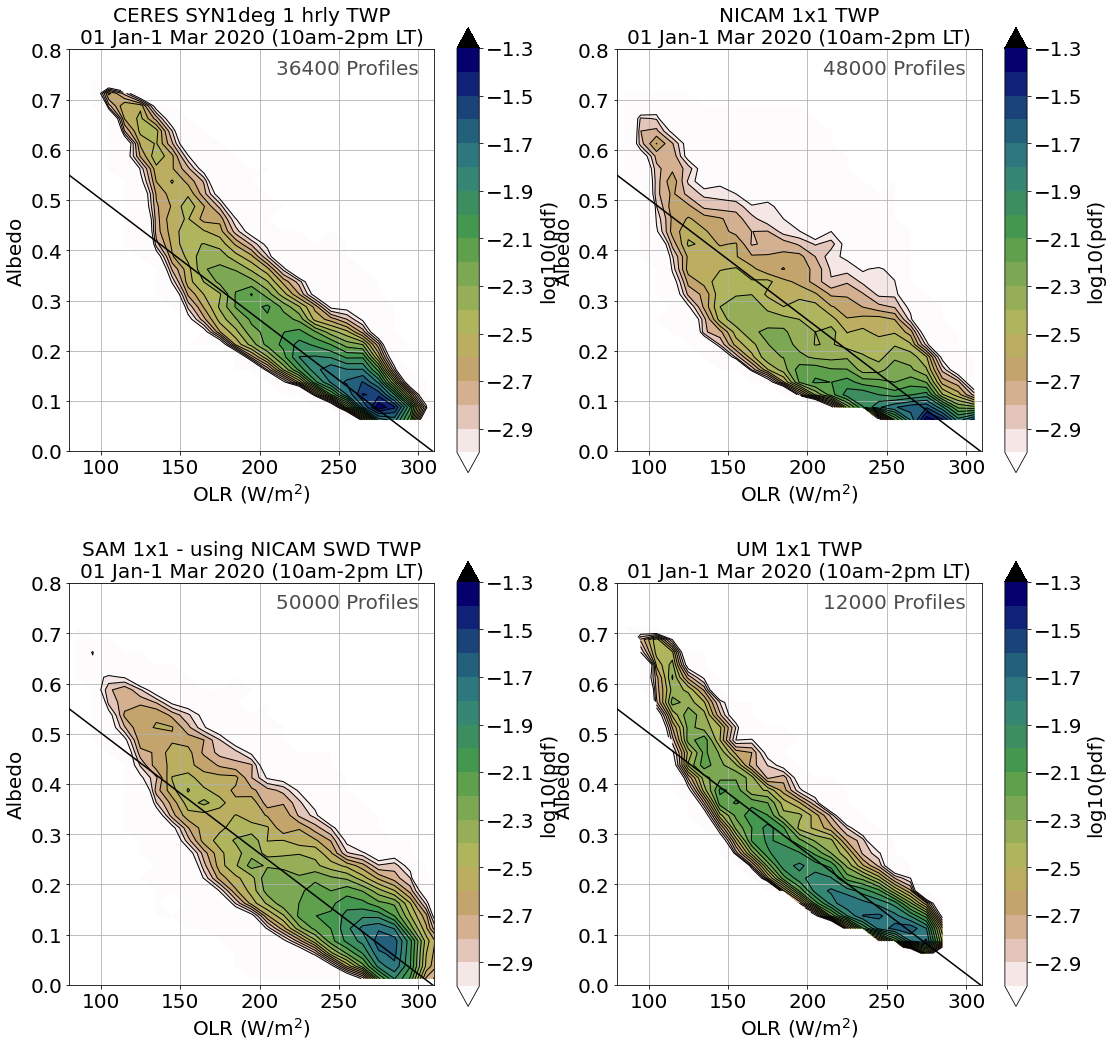

In [34]:
fig = plt.figure(figsize=(18,18))
axes = [fig.add_subplot(2,2,i,box_aspect=1.1) for i in range(1,5)]
i = 0
models=["CERES SYN1deg 1 hrly", "NICAM 1x1", "SAM 1x1 - using NICAM SWD", "UM 1x1"]
olrs=[da_olr, ni_olr, sa_olr, um_olr]
albs=[da_alb, ni_alb, sa_alb, um_alb]
for i in range(len(olrs)):
    olr = olrs[i]
    alb = albs[i]
    olr = olr.where((olr.time.dt.hour>=0)&(olr.time.dt.hour<=4))
    alb = alb.where((alb.time.dt.hour>=0)&(alb.time.dt.hour<=4))
    util.dennisplot("density",olr.values.flatten(), alb.values.flatten(), 
                ax=axes[i], model=models[i], region=region, cmap="gist_earth_r")
    axes[i].set_xlabel("OLR (W/m$^2$)")
    axes[i].set_ylabel("Albedo")
    axes[i].grid(True)
    axes[i].set_ylim([0,0.8])
    axes[i].set_title("{} {}\n01 Jan-1 Mar 2020 (10am-2pm LT)".format(models[i], region), fontsize=20)
    i+=1
plt.savefig("../plots/jhist_{}.png".format(region))
plt.show()

In [42]:
sa_alblow = sa_alb.where(sa_alb.values<0.05)
sa_olrlow = sa_olr.where(sa_alb.values<0.05)
plt.scatter(sa_olrlow, sa_alblow)

[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.3s


ValueError: operands could not be broadcast together with shapes (2976, 10, 10) (2976, 256, 256) ()

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s


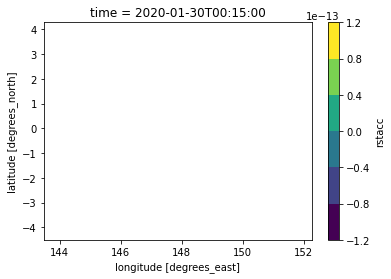

In [39]:
t=1
sa_alb[t,:,:].plot.contourf(x="lon",y="lat")
sa_alblow[t,:,:].plot.contour(x="lon", y="lat", color="r", levels=[0.05])